# Constants

In [1]:
IALAB_USER = 'jiossandon'

# Imports

In [2]:
import os
import os.path as osp
import json
import sys

In [3]:
matterport_build_path = f'/home/{IALAB_USER}/datasets/Matterport3DSimulator/build'
metadata_script_path = f'/home/{IALAB_USER}/repos/360-visualization/metadata_parser'

In [4]:
if matterport_build_path not in sys.path:
    sys.path.append(matterport_build_path)

if metadata_script_path not in sys.path:
    sys.path.append(metadata_script_path)

In [5]:
import json
import sys
import MatterSim
import time
import numpy as np
import skimage.transform
import networkx as nx

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from parse_house_segmentations import HouseSegmentationFile

# Simulator

In [6]:
# load navigation graph to calculate the relative heading of the next location
def load_nav_graph(graph_path):
    with open(graph_path) as f:
        G = nx.Graph()
        positions = {}
        data = json.load(f)
        for i,item in enumerate(data):
            if item['included']:
                for j,conn in enumerate(item['unobstructed']):
                    if conn and data[j]['included']:
                        positions[item['image_id']] = np.array([item['pose'][3], 
                                item['pose'][7], item['pose'][11]]);
                        assert data[j]['unobstructed'][i], 'Graph should be undirected'
                        G.add_edge(item['image_id'],data[j]['image_id'])
        nx.set_node_attributes(G, values=positions, name='position')
    return G

def compute_rel_heading(graph, current_viewpoint, current_heading, next_viewpoint):
    if current_viewpoint == next_viewpoint:
        return 0.
    target_rel = graph.nodes[next_viewpoint]['position'] - graph.nodes[current_viewpoint]['position']
    target_heading = np.pi/2.0 - np.arctan2(target_rel[1], target_rel[0]) # convert to rel to y axis
    
    rel_heading = target_heading - current_heading

    # normalize angle into turn into [-pi, pi]
    rel_heading = rel_heading - (2*np.pi) * np.floor((rel_heading + np.pi) / (2*np.pi))
    return rel_heading

In [7]:
def visualize_panorama_img(scan, viewpoint, heading, elevation):
    WIDTH = 80
    HEIGHT = 480
    pano_img = np.zeros((HEIGHT, WIDTH*36, 3), np.uint8)
    VFOV = np.radians(55)
    sim = MatterSim.Simulator()
    sim.setCameraResolution(WIDTH, HEIGHT)
    sim.setCameraVFOV(VFOV)
    sim.initialize()
    for n_angle, angle in enumerate(range(-175, 180, 10)):
        sim.newEpisode([scan], [viewpoint], [heading + np.radians(angle)], [elevation])
        state = sim.getState()
        im = state[0].rgb
        im = np.array(im)
        pano_img[:, WIDTH*n_angle:WIDTH*(n_angle+1), :] = im[..., ::-1]
    return pano_img

def visualize_tunnel_img(scan, viewpoint, heading, elevation):
    WIDTH = 640
    HEIGHT = 480
    VFOV = np.radians(60)
    sim = MatterSim.Simulator()
    sim.setCameraResolution(WIDTH, HEIGHT)
    sim.setCameraVFOV(VFOV)
    sim.init()
    sim.newEpisode(scan, viewpoint, heading, elevation)
    state = sim.getState()
    im = state.rgb
    return im[..., ::-1].copy()

## Initialize data for after processing

In [8]:
from collections import defaultdict

viewpoints_information = defaultdict(dict)

## Get Objects with Reverie

In [9]:
!pip install typing

In [22]:
from typing import Dict, List, Tuple

BBox = Tuple[int, int, int, int]
ViewpointPosObjects = Dict[str, BBox]
ObjProposals = Dict[str, ViewpointPosObjects]

ViewpointList = List[str]
Obj2Viewpoint = Dict[str, ViewpointList]

Obj2Name = Dict[str, str]


def loadObjProposals(bboxDir: str) -> Tuple[ObjProposals, Obj2Viewpoint]:
    objProposals: ObjProposals = {}
    obj2viewpoint: Obj2Viewpoint = {}
    obj2name: Obj2Name = {}
    for efile in os.listdir(bboxDir):
        if efile.endswith('.json'):
            with open(osp.join(bboxDir, efile)) as f:
                scan = efile.split('_')[0]
                scanvp, _ = efile.split('.')
                data = json.load(f)
                for vp, vv in data.items():
                    for objid, objinfo in vv.items():
                        if objinfo['visible_pos']:
                            if scan + '_' + objid in obj2viewpoint:
                                if vp not in obj2viewpoint[scan + '_' + objid]:
                                    obj2viewpoint[scan + '_' + objid].append(vp)
                            else:
                                obj2viewpoint[scan + '_' + objid] = [vp, ]

                            if scanvp not in objProposals:
                                objProposals[scanvp] = {}

                            for pos, bbox in zip(objinfo['visible_pos'], objinfo['bbox2d']):
                                if pos not in objProposals[scanvp]:
                                    objProposals[scanvp][pos] = {}

                                objProposals[scanvp][pos][objinfo['name']] = tuple(bbox)

                        obj2name[scan + '_' + objid] = objinfo['name']

    return objProposals, obj2viewpoint, obj2name

props, o2v, o2n = loadObjProposals('./BBox')

In [ ]:
def get_objects_by_scanviewpointid(viewpoint, scan, heading):
    objects = props[f'{scan}_{viewpoint}']
    
    
    
    
{4: {'486': (503, 161, 137, 225)}, 5: {'486': (317, 137, 323, 208)}, 6: {'486': (111, 125, 450, 196)}, 7: {'486': (0, 122, 335, 264)}, 8: {'486': (0, 164, 133, 189)}, 16: {'486': (563, 386, 77, 94)}, 17: {'486': (316, 359, 324, 121)}, 18: {'486': (83, 347, 500, 133)}, 19: {'486': (0, 345, 337, 135)}, 20: {'486': (0, 390, 102, 90)}, 22: {'495': (398, 0, 33, 15)}, 23: {'495': (174, 0, 43, 6)}, 24: {'495': (0, 95, 59, 89)}, 33: {'495': (581, 93, 59, 109)}, 34: {'495': (381, 168, 58, 83)}, 35: {'495': (193, 169, 64, 76)}}

# Visualization

In [23]:
LABEL_MAPPING = {
    'a': 'bathroom',
    'b': 'bedroom',
    'c': 'closet',
    'd': 'dining room',
    'e': 'entryway/foyer/lobby',
    'f': 'familyroom',
    'g': 'garage',
    'h': 'hallway',
    'i': 'library',
    'j': 'laundryroom/mudroom',
    'k': 'kitchen',
    'l': 'living room',
    'm': 'meetingroom/conferenceroom',
    'n': 'lounge',
    'o': 'office',
    'p': 'porch/terrace/deck/driveway',
    'r': 'rec/game',
    's': 'stairs',
    't': 'toilet',
    'u': 'utilityroom/toolroom',
    'v': 'tv',
    'w': 'workout/gym/exercise',
    'x': 'outdoor areas containing grass, plants, bushes, trees, etc.',
    'y': 'balcony',
    'z': 'other room',
    'B': 'bar',
    'C': 'classroom',
    'D': 'dining booth',
    'S': 'spa/sauna',
    'Z': 'junk',
    '-': 'no label'
}

def get_viewpoint_region_name(metadata, viewpoint):
    label_keyword = metadata.get_region(viewpoint).label.values[0]
    return LABEL_MAPPING[label_keyword]

In [24]:
def visualize(scan, viewpoint, viewpoint_heading, next_viewpoint, metadata):
    objects = metadata.angle_relative_viewpoint_objects(viewpoint)
    
    # Add to post processing data
    viewpoints_information[viewpoint]['objects'] = []
    viewpoints_information[viewpoint]['viewpoints'] = []

    connectivity_path = f'/home/{IALAB_USER}/repos/360-visualization/connectivity/{scan}_connectivity.json'
    reachable_viewpoints = metadata.angle_relative_reachable_viewpoints(viewpoint, connectivity_path)

    images = []
    for viewpoint_elevation in (np.pi / 2 * x for x in range(-1, 2)):
        im = visualize_panorama_img(scan, viewpoint, viewpoint_heading, viewpoint_elevation)
        images.append(im)

    img = np.concatenate(images[::-1], axis=0)
    
    plt.figure(figsize=(18, 9))  
    plt.imshow(img)
    plt.xticks(np.linspace(0, img.shape[1] - 1, 5), [-180, -90, 0, 90, 180])
    plt.xlabel(f'relative heading from the agent. -90° is left, 90° is right, and (-)180° is behind')
    plt.yticks(np.linspace(0, img.shape[0] - 1, 5), [-180, -90, 0, 90, 180])
    
    next_heading = viewpoint_heading
    x0, y0 = viewpoint_heading, 0
    for obj in objects.itertuples():
        heading, elevation = float(obj.heading), float(obj.elevation)
        category = obj.category_mapping_name

        heading -= x0
        while heading > np.pi:
            heading -= 2 * np.pi
        while heading < -np.pi:
            heading += 2 * np.pi

        elevation += y0
        while elevation > np.pi:
            heading -= 2 * np.pi
        while elevation < -np.pi:
            elevation += 2 * np.pi

        first_coord = (heading / (2 * np.pi) + 0.5) * img.shape[1]
        second_coord = (0.5 - elevation / (np.pi / 1.1)) * img.shape[0]
        
        # Add to post processing data
        viewpoints_information[viewpoint]['objects'].append(
            [
                category, 
                first_coord / img.shape[1] * 2 * np.pi,
                obj.distance,
                (obj.r0, obj.r1, obj.r2)
            ]
        )
        
        # print(f"Name: {category}, (r0, r1, r2): {obj.r0},{obj.r1},{obj.r2}")
        plt.plot(first_coord, second_coord, color='red', marker='v', linewidth=3)
        plt.text(first_coord, second_coord, category, color='white', backgroundcolor='black')


    for reachable_viewpoint in reachable_viewpoints.itertuples():
        heading, elevation = float(reachable_viewpoint.heading), float(reachable_viewpoint.elevation)
        
        heading -= x0
        while heading > np.pi:
            heading -= 2 * np.pi
        while heading < -np.pi:
            heading += 2 * np.pi

        elevation += y0
        while elevation > np.pi:
            heading -= 2 * np.pi
        while elevation < -np.pi:
            elevation += 2 * np.pi

        first_coord = (heading / (2 * np.pi) + 0.5) * img.shape[1]
        second_coord = (0.5 - elevation / (np.pi / 1.1)) * img.shape[0]
                
        if reachable_viewpoint.name == next_viewpoint:
            next_heading += heading
            plt.arrow(first_coord, second_coord + 150, 0, -50, width=20, color='green')
        
        region_name_of_viewpoint = get_viewpoint_region_name(metadata, reachable_viewpoint.name)
        
        # Add to post processing data
        viewpoints_information[viewpoint]['viewpoints'].append(
            [region_name_of_viewpoint, 
             first_coord / img.shape[1] * 2 * np.pi]
        )
        
        plt.text(first_coord - 20, second_coord - 10, region_name_of_viewpoint, color='black')
        plt.plot(first_coord, second_coord, color='blue', marker='o', 
                 markersize= 15 / reachable_viewpoint.distance, linewidth=1)
            
    return next_heading

In [25]:
plt.close('all')

### Define the instruction to overview

In [26]:
instructions_path = f'/home/{IALAB_USER}/repos/objects-auxiliary/paths/R2R_train.json'
instruction_index = 25

In [27]:
with open(instructions_path, 'r') as f:
    data = json.load(f)
    print(f"The file contain {len(data)} paths. The index must be between 0 and {len(data) - 1}.")
    instruction_data = data[instruction_index]
    
scan = instruction_data['scan']
viewpoints_sequence = instruction_data['path']
initial_heading = instruction_data['heading']

The file contain 4675 paths. The index must be between 0 and 4674.


### Set the metadata and cell display

In [28]:
metadata = metadata = HouseSegmentationFile.load_mapping(scan)
print("Press 'Shift + O' on Jupyter Notebook for avoid cell collapse")

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>")) # Bigger height of the cell output

Cached file exists, loading.
Press 'Shift + O' on Jupyter Notebook for avoid cell collapse


### Plot viewpoints and save the data

- Walk out of the bathroom into the hallway. Walk passed the cabinet and wall mirror and continue down the hall. Walk passed the water cooler and into the next room ahead. Walk towards the large circular desk area near the pamphlets laid out on the desk. 

- Walk through doorway and turn right. Walk straight and go through the next doorway. Walk forward and then turn right. Wait by the reception desk. 

- Turn around and walk down the part of the floor next to the large dark-brown framed mirror. Walk straight out the door and make a right towards the reception desk. 
{4: {'486': (503, 161, 137, 225)}, 5: {'486': (317, 137, 323, 208)}, 6: {'486': (111, 125, 450, 196)}, 7: {'486': (0, 122, 335, 264)}, 8: {'486': (0, 164, 133, 189)}, 16: {'486': (563, 386, 77, 94)}, 17: {'486': (316, 359, 324, 121)}, 18: {'486': (83, 347, 500, 133)}, 19: {'486': (0, 345, 337, 135)}, 20: {'486': (0, 390, 102, 90)}, 22: {'495': (398, 0, 33, 15)}, 23: {'495': (174, 0, 43, 6)}, 24: {'495': (0, 95, 59, 89)}, 3

{2: {'503': (607, 66, 33, 96), '507': (593, 233, 47, 70), '512': (528, 232, 112, 248)}, 3: {'503': (361, 0, 279, 137), '507': (378, 122, 262, 135), '512': (366, 193, 274, 287)}, 4: {'503': (102, 0, 346, 147), '507': (175, 108, 310, 151), '512': (171, 134, 318, 346)}, 5: {'503': (0, 0, 199, 149), '507': (0, 122, 264, 176), '512': (0, 134, 282, 346)}, 14: {'503': (617, 75, 23, 312)}, 15: {'503': (360, 97, 280, 262), '507': (387, 345, 253, 135), '512': (381, 421, 259, 59)}, 16: {'503': (131, 87, 302, 283), '507': (161, 331, 328, 149), '512': (156, 357, 340, 123)}, 17: {'503': (0, 83, 210, 290), '507': (0, 345, 262, 135), '512': (89, 357, 180, 123)}, 26: {'503': (603, 287, 37, 123)}, 27: {'503': (360, 321, 280, 159)}, 28: {'503': (102, 312, 348, 168)}, 29: {'503': (0, 304, 205, 176)}, 6: {'507': (0, 166, 13, 18), '512': (0, 167, 100, 313)}, 18: {'512': (0, 396, 7, 84)}}
{2: {'503': (607, 66, 33, 96), '507': (593, 233, 47, 70), '512': (528, 232, 112, 248)}, 3: {'503': (361, 0, 279, 137), '5

{0: {'509': (504, 254, 136, 226)}, 1: {'509': (339, 176, 179, 282)}, 2: {'509': (167, 177, 157, 246)}, 3: {'509': (0, 216, 179, 264), '517': (573, 244, 29, 53)}, 13: {'509': (409, 402, 138, 78)}, 14: {'509': (185, 404, 125, 76)}, 15: {'509': (0, 449, 66, 31), '517': (459, 90, 181, 129)}, 4: {'517': (362, 206, 16, 46)}, 5: {'517': (159, 219, 27, 46)}, 16: {'517': (235, 96, 169, 384)}, 17: {'517': (0, 70, 180, 410)}, 27: {'517': (453, 314, 187, 85)}, 28: {'517': (237, 319, 169, 139)}, 29: {'517': (0, 287, 178, 170)}}
{0: {'509': (504, 254, 136, 226)}, 1: {'509': (339, 176, 179, 282)}, 2: {'509': (167, 177, 157, 246)}, 3: {'509': (0, 216, 179, 264), '517': (573, 244, 29, 53)}, 13: {'509': (409, 402, 138, 78)}, 14: {'509': (185, 404, 125, 76)}, 15: {'509': (0, 449, 66, 31), '517': (459, 90, 181, 129)}, 4: {'517': (362, 206, 16, 46)}, 5: {'517': (159, 219, 27, 46)}, 16: {'517': (235, 96, 169, 384)}, 17: {'517': (0, 70, 180, 410)}, 27: {'517': (453, 314, 187, 85)}, 28: {'517': (237, 319, 169

{14: {'506': (426, 79, 104, 112), '513': (490, 352, 148, 115), '517': (14, 116, 82, 62)}, 15: {'506': (204, 89, 93, 105), '513': (263, 338, 161, 142)}, 16: {'506': (0, 52, 48, 131), '513': (0, 351, 202, 129)}, 26: {'506': (430, 304, 110, 115), '517': (9, 340, 89, 63)}, 27: {'506': (196, 314, 100, 109)}, 28: {'506': (0, 278, 55, 130)}, 1: {'513': (608, 422, 32, 58), '518': (415, 354, 171, 126)}, 2: {'513': (411, 130, 229, 350), '518': (277, 317, 124, 163)}, 3: {'513': (259, 115, 154, 365), '518': (135, 340, 111, 140)}, 4: {'513': (14, 129, 235, 351), '518': (0, 426, 68, 54)}, 5: {'513': (0, 339, 54, 141)}, 12: {'517': (502, 115, 75, 60)}, 13: {'517': (273, 133, 59, 52)}, 24: {'517': (505, 338, 86, 62)}, 25: {'517': (272, 355, 61, 57)}}
{14: {'506': (426, 79, 104, 112), '513': (490, 352, 148, 115), '517': (14, 116, 82, 62)}, 15: {'506': (204, 89, 93, 105), '513': (263, 338, 161, 142)}, 16: {'506': (0, 52, 48, 131), '513': (0, 351, 202, 129)}, 26: {'506': (430, 304, 110, 115), '517': (9, 

{2: {'66': (422, 269, 73, 202)}, 3: {'66': (280, 253, 53, 200)}, 4: {'66': (75, 292, 110, 188)}}
{2: {'66': (422, 269, 73, 202)}, 3: {'66': (280, 253, 53, 200)}, 4: {'66': (75, 292, 110, 188)}}
{2: {'66': (422, 269, 73, 202)}, 3: {'66': (280, 253, 53, 200)}, 4: {'66': (75, 292, 110, 188)}}
{2: {'66': (422, 269, 73, 202)}, 3: {'66': (280, 253, 53, 200)}, 4: {'66': (75, 292, 110, 188)}}
{2: {'66': (422, 269, 73, 202)}, 3: {'66': (280, 253, 53, 200)}, 4: {'66': (75, 292, 110, 188)}}
{2: {'66': (422, 269, 73, 202)}, 3: {'66': (280, 253, 53, 200)}, 4: {'66': (75, 292, 110, 188)}}
{2: {'66': (422, 269, 73, 202)}, 3: {'66': (280, 253, 53, 200)}, 4: {'66': (75, 292, 110, 188)}}
{2: {'66': (422, 269, 73, 202)}, 3: {'66': (280, 253, 53, 200)}, 4: {'66': (75, 292, 110, 188)}}
{2: {'66': (422, 269, 73, 202)}, 3: {'66': (280, 253, 53, 200)}, 4: {'66': (75, 292, 110, 188)}}
{2: {'66': (422, 269, 73, 202)}, 3: {'66': (280, 253, 53, 200)}, 4: {'66': (75, 292, 110, 188)}}
{2: {'66': (422, 269, 73, 202)

{0: {'101': (265, 56, 119, 260)}, 1: {'101': (23, 63, 162, 287)}, 11: {'101': (475, 65, 154, 286)}, 12: {'101': (261, 285, 131, 195)}, 13: {'101': (0, 291, 167, 189)}, 23: {'101': (488, 292, 152, 188)}}
{0: {'101': (265, 56, 119, 260)}, 1: {'101': (23, 63, 162, 287)}, 11: {'101': (475, 65, 154, 286)}, 12: {'101': (261, 285, 131, 195)}, 13: {'101': (0, 291, 167, 189)}, 23: {'101': (488, 292, 152, 188)}}
{0: {'101': (265, 56, 119, 260)}, 1: {'101': (23, 63, 162, 287)}, 11: {'101': (475, 65, 154, 286)}, 12: {'101': (261, 285, 131, 195)}, 13: {'101': (0, 291, 167, 189)}, 23: {'101': (488, 292, 152, 188)}}
{0: {'101': (265, 56, 119, 260)}, 1: {'101': (23, 63, 162, 287)}, 11: {'101': (475, 65, 154, 286)}, 12: {'101': (261, 285, 131, 195)}, 13: {'101': (0, 291, 167, 189)}, 23: {'101': (488, 292, 152, 188)}}
{0: {'101': (265, 56, 119, 260)}, 1: {'101': (23, 63, 162, 287)}, 11: {'101': (475, 65, 154, 286)}, 12: {'101': (261, 285, 131, 195)}, 13: {'101': (0, 291, 167, 189)}, 23: {'101': (488, 29

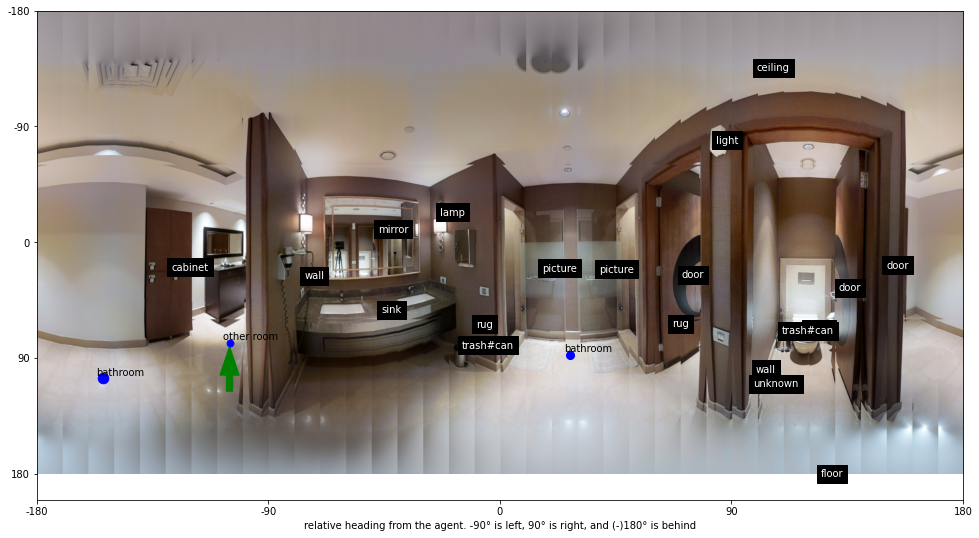

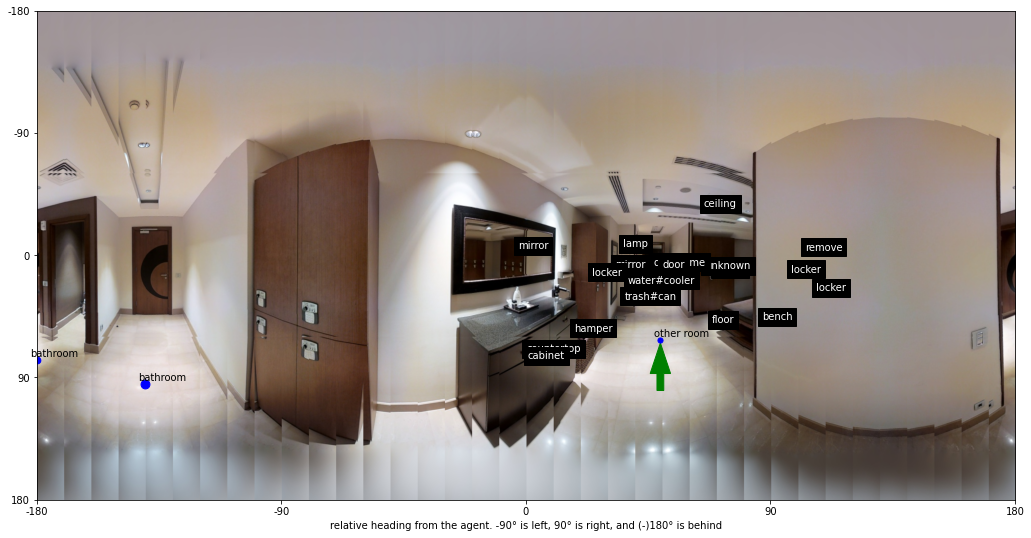

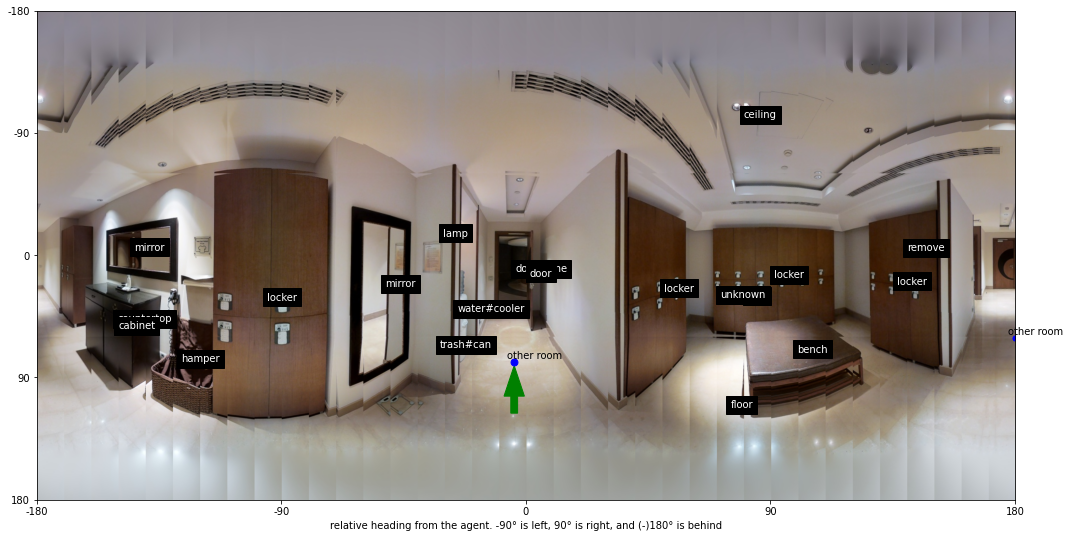

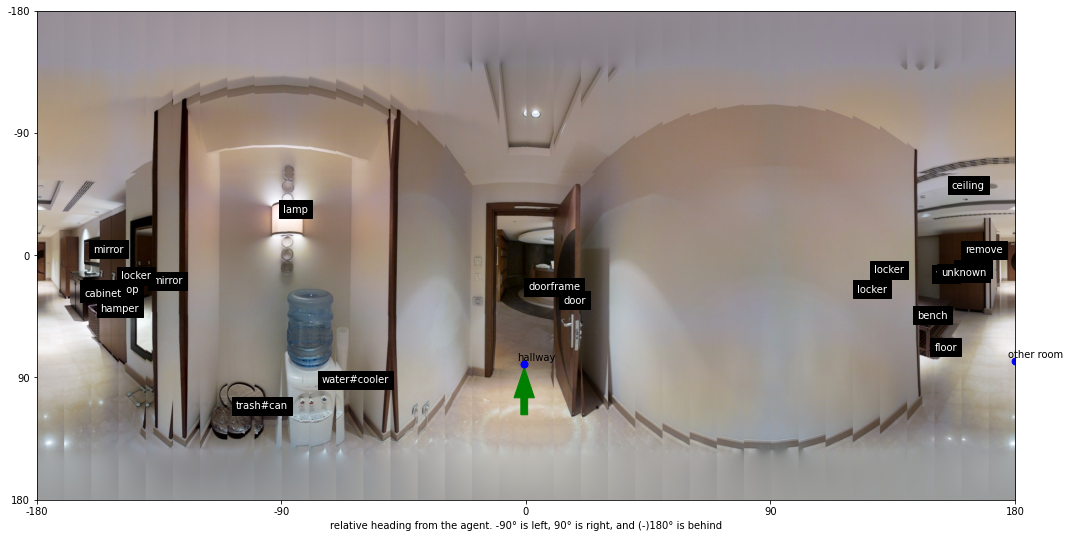

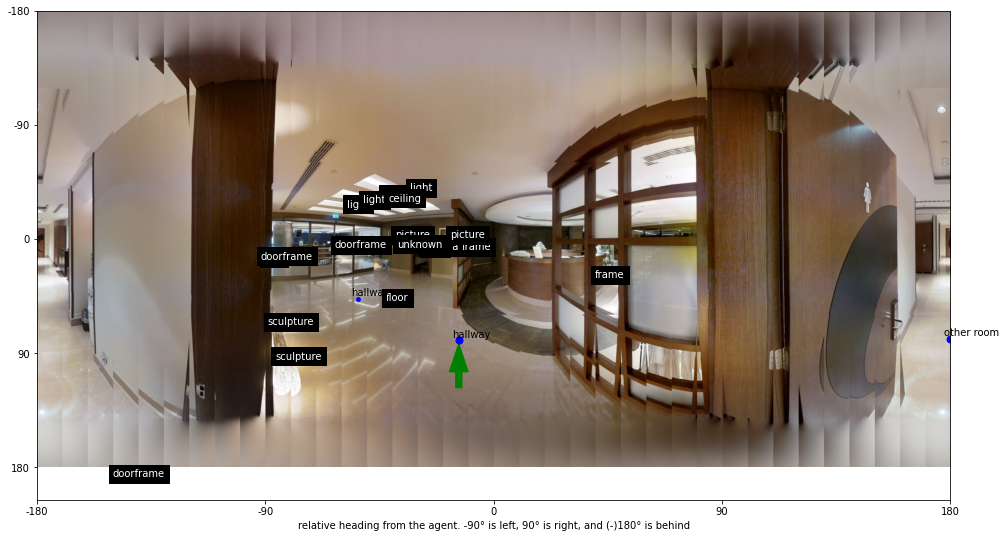

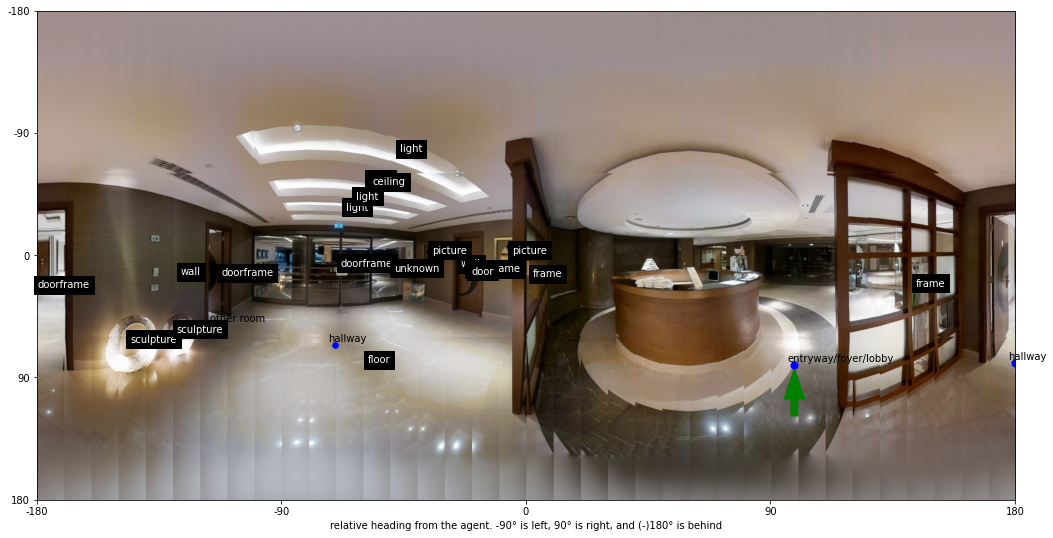

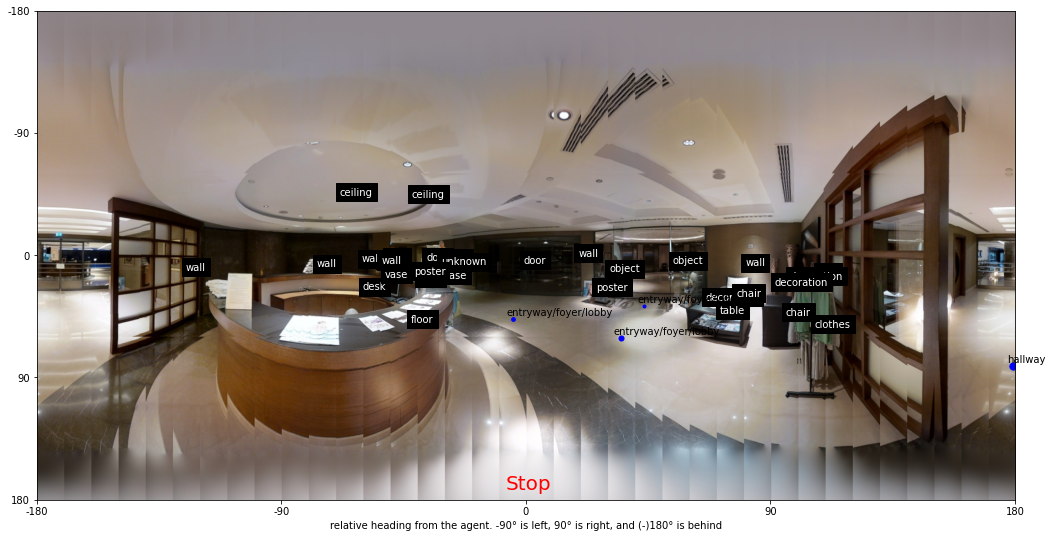

In [29]:
# Instructions
instructions = "- " + "\n\n- ".join(instruction_data['instructions'])
print(instructions)

heading = initial_heading
for idx, viewpoint in enumerate(viewpoints_sequence):
    if idx < len(viewpoints_sequence) - 1:
        heading = visualize(scan, viewpoint, heading, viewpoints_sequence[idx + 1], metadata)
    else:
        heading = visualize(scan, viewpoint, heading, viewpoints_sequence[idx], metadata)
        plt.text(2880 // 2 - 60, 1440 - 30, 'Stop', fontsize=20, color='r') # Stop

## Objects presence on instructions

In [30]:
!pip install spacy

!python -m spacy download en_core_web_sm

     |████████████████████████████████| 13.6 MB 16.3 MB/s eta 0:00:01


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [31]:
import numpy as np

def get_reference(heading):
    pi = np.pi
    if pi/2 <= heading < (pi - 1/2):
        return 'left'
    elif (pi - 1/2) <= heading <= (pi + 1/2):
        return 'front'
    elif (pi + 1/2) < heading < 3 * pi/2:
        return 'right'
    else:
        return 'behind'
    
FORBIDDEN_WORDS = ['wall', 'unknown', 'floor', 'ceiling']
def used_data(instruction_nouns, objects, viewpoints, current_region):
    used_objects = []
    used_viewpoints = []
    for idx, noun in enumerate(instruction_nouns):
        percentage = round((idx + 1) / len(instruction_nouns) * 100, 2)
        
        for obj in objects:
            name, heading, distance, radius = obj
            if name in FORBIDDEN_WORDS:
                continue
            if noun in name.split("#"):
                used_objects.append([percentage, name, heading, get_reference(heading), distance])
        for viewpoint in viewpoints:
            name, heading = viewpoint
            if noun in name.split("#"):
                if name != current_region:
                    used_viewpoints.append([percentage, name, heading, get_reference(heading)])
                else:
                    used_viewpoints.append([percentage, name, heading, 'current and ' + get_reference(heading)])
    return used_objects, used_viewpoints            
    

In [32]:
import spacy

nlp = spacy.load("en_core_web_sm")

instructions = instruction_data['instructions']

total_viewpoints = len(viewpoints_sequence)
instruction_elements = []
for instruction in instructions:
    elements = []
    doc = nlp(instruction)

    # Nouns only
    # instruction_nouns = [token.text for token in doc if token.pos_ == "NOUN"]

    # All
    instruction_nouns = [token.text for token in doc]
    
    # Agent navigation for each node
    for index, viewpoint in enumerate(viewpoints_sequence):
        current_region = get_viewpoint_region_name(metadata, viewpoint)

        viewpoint_info = viewpoints_information[viewpoint]
        data = used_data(
            instruction_nouns, 
            viewpoint_info['objects'], 
            viewpoint_info['viewpoints'],
            current_region
        )
        
        percentage = round((index + 1)/len(viewpoints_sequence) * 100, 2)

        for element in data[0]:
            elements.append({
                'name': element[1],
                'instruction_position_percentage': element[0],
                'path_percentage': percentage,
                'heading': element[2],
                'relative_position': element[3],
                'distance': element[4]
            })
        for element in data[1]:
            elements.append({
                'name': element[1],
                'instruction_position_percentage': element[0],
                'path_percentage': percentage,
                'heading': element[2],
                'relative_position': element[3]
            })

        instruction_elements.append({
            'instruction': instruction,
            'elements': elements
        })

instruction_elements

[{'instruction': 'Walk out of the bathroom into the hallway. Walk passed the cabinet and wall mirror and continue down the hall. Walk passed the water cooler and into the next room ahead. Walk towards the large circular desk area near the pamphlets laid out on the desk. ',
  'elements': [{'name': 'cabinet',
    'instruction_position_percentage': 26.0,
    'path_percentage': 14.29,
    'heading': 0.9128026337140475,
    'relative_position': 'behind',
    'distance': 2.5122049315491775},
   {'name': 'mirror',
    'instruction_position_percentage': 32.0,
    'path_percentage': 14.29,
    'heading': 2.311238818203992,
    'relative_position': 'left',
    'distance': 2.0451860282135708},
   {'name': 'bathroom',
    'instruction_position_percentage': 10.0,
    'path_percentage': 14.29,
    'heading': 0.4481286730997481,
    'relative_position': 'current and behind'},
   {'name': 'bathroom',
    'instruction_position_percentage': 10.0,
    'path_percentage': 14.29,
    'heading': 3.6173529402

In [33]:
props

{'q9vSo1VnCiC_00ba88e9785b41628acd0a1f054822af': {0: {'7': (120, 0, 138, 348),
   '11': (212, 117, 321, 363)},
  1: {'7': (0, 158, 58, 278), '11': (0, 124, 341, 356)},
  5: {'7': (572, 237, 68, 243)},
  6: {'7': (385, 0, 184, 404)},
  7: {'7': (167, 0, 142, 384)},
  8: {'7': (0, 0, 136, 434)},
  10: {'7': (531, 119, 109, 297), '11': (591, 330, 49, 150)},
  11: {'7': (348, 0, 143, 343), '11': (406, 142, 234, 338)},
  12: {'7': (129, 0, 129, 480), '11': (207, 340, 334, 140)},
  18: {'7': (401, 0, 142, 480)},
  19: {'7': (177, 0, 141, 480)},
  20: {'7': (0, 0, 62, 480)},
  22: {'7': (631, 0, 9, 480)},
  23: {'7': (336, 0, 148, 480), '11': (430, 365, 210, 115)},
  24: {'7': (0, 0, 240, 480)},
  25: {'7': (0, 141, 15, 59)},
  29: {'7': (631, 135, 9, 42)},
  30: {'7': (410, 0, 230, 480)},
  31: {'7': (167, 0, 423, 480)},
  32: {'7': (0, 0, 604, 480)},
  33: {'7': (0, 0, 640, 101)},
  34: {'7': (35, 0, 605, 366)},
  35: {'7': (54, 0, 437, 480)},
  2: {'11': (0, 239, 158, 241)},
  13: {'11': (